In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_heston_euler(S0, v0, T, N, mu, kappa, theta, xi, rho):
    dt = T / N
    t = np.linspace(0, T, N+1)

    S = np.zeros(N+1)
    v = np.zeros(N+1)
    S[0], v[0] = S0, v0

    for k in range(N):
        Z1 = np.random.randn()
        Z2 = np.random.randn()

        dW1 = np.sqrt(dt) * Z1
        dW2 = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho**2) * Z2)

        v_pos = max(v[k], 0.0)

        # Euler para v (full truncation)
        v[k+1] = v[k] + kappa * (theta - v_pos) * dt + xi * np.sqrt(v_pos) * dW2
        v[k+1] = max(v[k+1], 0.0)

        # Euler para S
        S[k+1] = S[k] + mu * S[k] * dt + np.sqrt(v_pos) * S[k] * dW1

    return t, S, v

In [2]:
def comparar_heston(S0=100, v0=0.04, T=1.0, N_big=252, M=10,
                    mu=0.05, kappa=2.0, theta=0.04, xi=0.5, rho=-0.7):

    N_small = N_big * M
    dt_small = T / N_small
    dt_big = T / N_big

    # Brownianos en malla fina
    Z1_small = np.random.randn(N_small)
    Z2_small = np.random.randn(N_small)

    dW1_small = np.sqrt(dt_small) * Z1_small
    dW2_small = np.sqrt(dt_small) * (rho * Z1_small + np.sqrt(1 - rho**2) * Z2_small)

    # Trayectoria "fina" (referencia)
    S_ref = np.zeros(N_small+1)
    v_ref = np.zeros(N_small+1)
    S_ref[0], v_ref[0] = S0, v0

    for k in range(N_small):
        v_pos = max(v_ref[k], 0.0)

        v_ref[k+1] = v_ref[k] + kappa * (theta - v_pos) * dt_small + xi * np.sqrt(v_pos) * dW2_small[k]
        v_ref[k+1] = max(v_ref[k+1], 0.0)

        S_ref[k+1] = S_ref[k] + mu * S_ref[k] * dt_small + np.sqrt(v_pos) * S_ref[k] * dW1_small[k]

    # Submuestreo en tiempos "gruesos"
    idx_big = np.arange(0, N_small+1, M)
    t_big = idx_big * dt_small
    S_ref_big = S_ref[idx_big]

    # Trayectoria "esquema grueso" usando mismos Brownianos agregados
    S_big = np.zeros(N_big+1)
    v_big = np.zeros(N_big+1)
    S_big[0], v_big[0] = S0, v0

    for j in range(N_big):
        # agrego M incrementos pequeños
        dW1 = dW1_small[j*M:(j+1)*M].sum()
        dW2 = dW2_small[j*M:(j+1)*M].sum()

        v_pos = max(v_big[j], 0.0)

        v_big[j+1] = v_big[j] + kappa * (theta - v_pos) * dt_big + xi * np.sqrt(v_pos) * dW2
        v_big[j+1] = max(v_big[j+1], 0.0)

        S_big[j+1] = S_big[j] + mu * S_big[j] * dt_big + np.sqrt(v_pos) * S_big[j] * dW1

    # Gráfico
    plt.figure(figsize=(8,5))
    plt.plot(t_big, S_big, label="Simulación esquema (dt grande)")
    plt.plot(t_big, S_ref_big, "--", label="\"Solución\" de referencia (dt pequeño)")
    plt.xlabel("Tiempo")
    plt.ylabel("S(t)")
    plt.title("Comparación S(t) Heston: esquema vs referencia")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Métrica de error
    error = S_big - S_ref_big
    print("Error máximo:", np.max(np.abs(error)))
    print("RMSE:", np.sqrt(np.mean(error**2)))

    return t_big, S_big, S_ref_big

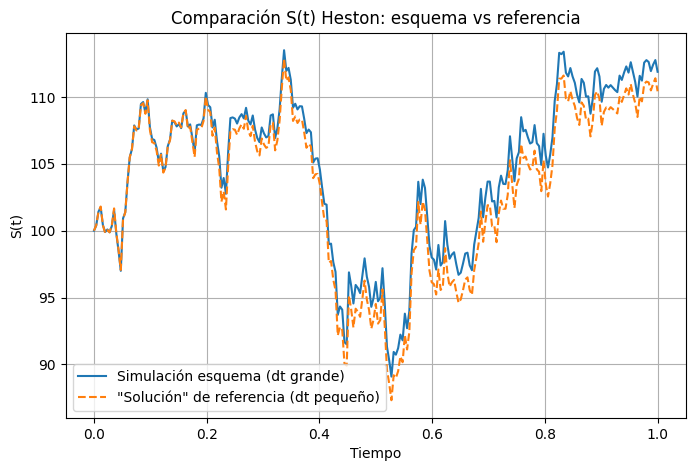

Error máximo: 2.173822375036721
RMSE: 1.4174069279693466


In [3]:
t_big, S_big, S_ref_big = comparar_heston()